In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from IPython.display import clear_output

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

pd.set_option('max_row', None)
pd.set_option('max_column', None)


class SinglePeriod:
    def __init__(
        self, 
        data,  
        preds, 
        budget, 
        sampler_args, 
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):
    
        self.df = data
        self.preds = preds
        self.budget = budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.init_budget = budget
        self.pct_returns = self.df.pct_change()
        self.stocks = self.df.columns.tolist()
        

        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}

        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.solution = {}
        self.precision = 2


    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        self.max_num_shares = (self.budget/self.df.loc[idx,:]).astype(int)
        #print(f'max num shares: {self.max_num_shares}')

        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}

        self.price = self.df.loc[idx, :]
        self.daily_returns = self.pct_returns.loc[:idx, :]
        print('self.daily_returns')
        display(self.daily_returns.head())
        print('self.preds')
        display(self.preds.head())
        self.avg_daily_returns = self.preds
        #print(f'avg_daily_returns')
        #print(self.avg_daily_returns.to_frame().columns)
        #display(self.avg_daily_returns)
        self.covariance_matrix = self.daily_returns.cov()
        
        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]

        print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0

            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')

           
        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            print('cqm debugging')
            print(f'risk: {type(risk)}')
            print(f'returns: {type(returns)}')
            print(returns)
            
            cqm.set_objective(self.alpha*risk - returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm

    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:        
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            #print(f'\nBest feasible solution:')
            #print("\n".join("{}\t{:>3}".format(k, v) for k, v in solution['stocks'].items()))
            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            print(f'solution: {solution}')
            solution_df = pd.DataFrame(solution)
            #print('solution_df')
            #display(solution_df.head())
            # if self.save_path:
            #     solution.to_pickle(save_path + 'single_period_solution.pkl')
            #return solution_df
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        variance = 0.0
        for s1, s2 in product(solution, solution):
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        for stock in solution:
            #est_return += solution[stock]*self.price[stock]*self.avg_daily_returns.loc[date, stock]
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self, 
                data, 
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):
    
        self.save_path = save_path
        self.df = data
        self.stocks = self.df.columns.values.tolist()
        
        self.sampler_args = sampler_args
        self.budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type

        #print(f'initial gspc: {self.baseline.query("Date==@dates[0]").values.tolist()}')

        initial_gspc = self.baseline.query('Date==@dates[0]').values.tolist()[0][0]
        print('initial baseline')
        display(self.baseline)
        print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        print('final baseline')
        display(self.baseline)

        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}
  
        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        #print(f'init holdings: {self.init_holdings.keys()}')
        self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        #print(f'self.stocks: {self.stocks}')
        self.df = self.df.loc[:, self.stocks].copy()
        #print(f'filtered df columns')
        #print(self.df.columns.values)
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)

        self.sample_set = {}
        self.sampler_args = sampler_args

        self.solution = {}
        
    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """
        
        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        result = {}
        baseline_result = {}
        #self.baseline_values = [0]
        #self.update_values = [0]
        days = []
        
        # dataframe to save output data
        #headers = ['Date', 'Value'] + self.stocks + ['Variance', 'Returns']
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'returns', 'value'])
        row = []
        

        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')
            df_train = self.df.loc[:idx, :]
            display(df_train.head())
            self.preds = predict_returns(df_train)
            self.price = self.df.loc[idx, :]
            baseline_current = self.baseline.loc[idx, :]
            single_period = SinglePeriod(data=self.df, 
                                         preds=self.preds.pct_change().iloc[-1,:], 
                                         budget=self.budget, 
                                         sampler_args=self.sampler_args, 
                                         dates=self.dates,
                                         model_type=self.model_type,
                                         alpha=self.alpha,
                                         verbose=self.verbose,
                                         t_cost=self.t_cost,
                                         label=self.label,
                                         init_holdings=self.init_holdings)

            if first_purchase:
                initial_budget = self.budget
                baseline_shares = (self.budget / baseline_current)
                display(self.baseline)
                #print(f'baseline shares: {baseline_shares}')
                #baseline_result = {self.baseline[0]: baseline_shares}
                #print(f'max_risk: {max_risk}')
                #print(f'min_return: {min_return}')
                #single_period.build_cqm(idx, max_risk=max_risk, min_return=min_return)
                self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
                #print(f'solution: {self.solution}')
                self.init_holdings = self.solution['stocks']

            else:
                self.budget = sum([self.df.iloc[-1][s]*self.solution['stocks'][s] for s in self.stocks])
                #self.update_values.append(self.budget - initial_budget)
                # Compute profit of fund portfolio
                #display(baseline_current)
                #fund_value = sum([baseline_current.iloc[-1][s]*baseline_result[s] for s in self.baseline])
                #self.baseline_values.append(fund_value - initial_budget)

                if self.t_cost and not first_purchase:
                    self.budget = 0
                #single_period.build_cqm(self, idx, max_risk=None, min_return=None)
                # print(f'max_risk: {max_risk}')
                # print(f'min_return: {min_return}')
                self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
                self.init_holdings = self.solution['stocks']

            #result_df = pd.DataFrame([self.solution['stocks']])
            #print('solution found')
            #display(result_df)
            #print(f'price: {self.price}')
            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            #print(f'value: {value}')
            returns = self.solution['return']
            variance = self.solution['risk']

            #row = [idx.strftime('%Y-%m-%d'), value] + [self.solution['stocks'][s] for s in self.stocks] #+ [variance, returns]
            #print(f'row: {row}')
            #print(f'self output columns: {self.output.columns}')
            #print(self.solution['stocks'])
            #print('display output')
            #print({s: self.solution['stocks'][s] for s in self.stocks})
            #display(pd.DataFrame([self.solution['stocks'][s] for s in self.stocks], columns = self.stocks))
            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            #display(self.output)
            #print('display agg_results')
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'returns': returns, 'value': value}])])
            
            #self.output = pd.concat([self.output, pd.DataFrame(row, columns = self.output.columns)])
            first_purchase = False

            clear_output(wait=True)
            initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / initial_budget - 1
            display(self.agg_results)
            
            fig = plt.figure(figsize=(10.708,8.2))
            sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            plt.show()
            print(f'\nRun completed.\n')

            self.output.to_pickle(self.save_path+'output.pkl')
            self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
            self.baseline.to_pickle(self.save_path+'baseline.pkl')

            print('First round concluded')
            #sys.exit()



        # #display(self.opt_results_df)
        
        # update_values = self.opt_results_df
        # print('Values')
        # print(update_values['Value'])
        
        # print(f'initial budget: {initial_budget}')
        
        # self.df_baseline.reset_index(inplace=True)
        # self.df_baseline['Date'] = self.df_baseline['Date'].dt.strftime('%Y-%m-%d')
        # 


        # if self.save_path:
        #     print(self.save_path)
        #     self.opt_results_df.to_pickle(self.save_path+'opt_results_df.pkl')
        #     self.df_all.to_pickle(self.save_path+'df_all.pkl')
        #     self.df_baseline.to_pickle(self.save_path+'df_baseline.pkl')
        #     update_values.to_pickle(self.save_path+'update_values.pkl')
        #     #self.daily_returns.to_pickle('daily_returns.pkl')
        #     #self.avg_daily_returns.to_pickle('avg_daily_returns.pkl')

        return None
        


        #     # Output for user on command-line and plot
        #     update_values = np.array(self.update_values, dtype=object)
        #     print(update_values)
        #     baseline_values = np.array(self.baseline_values, dtype=object)

        #     # Making solve run
        #     if self.model_type == 'DQM':
        #         print(f"\nMulti-Period DQM Run...")

        #         self.build_dqm()
        #         self.solution['DQM'] = self.solve_dqm()
        #         result = self.solution['DQM']
        #     else:
        #         print(f"\nMulti-Period CQM Run...")

        #         # Set budget to 0 to enforce that portfolio is self-financing
        #         if self.t_cost and not first_purchase:
        #             self.budget = 0

        #         #self.solution['CQM'] = self.solve_cqm(max_risk=max_risk, min_return=min_return, target_date=date)
        #         self.solution['CQM'] = self.solve_cqm(max_risk=max_risk, min_return=min_return, target_date=date)
        #         result = self.solution['CQM']
        #         self.init_holdings = result['stocks']

        #     result_df = pd.DataFrame(result)
        #     value = sum([self.price[s]*result['stocks'][s] for s in self.stocks])
        #     returns = result['return']
        #     variance = result['risk']


        #     row = [days[-1].strftime('%Y-%m-%d'), value] + [result['stocks'][s] for s in self.stocks] + [variance, returns]
        #     self.opt_results_df.loc[n] = row

        #     first_purchase = False


        # #display(self.opt_results_df)
        
        # update_values = self.opt_results_df
        # print('Values')
        # print(update_values['Value'])
        # initial_budget = update_values['Value'].values.tolist()[0]
        # print(f'initial budget: {initial_budget}')
        # update_values['Value2'] = update_values['Value'] / initial_budget - 1
        # self.df_baseline.reset_index(inplace=True)
        # self.df_baseline['Date'] = self.df_baseline['Date'].dt.strftime('%Y-%m-%d')
        # initial_gspc = self.df_baseline.query('Date==@dates[0]').values.tolist()[0][1]
        # self.df_baseline.iloc[:,1:] = (self.df_baseline.iloc[:,1:] / initial_gspc - 1)
        # fig = plt.figure(figsize=(10.708,8.2))
        # sns.scatterplot(x='Date', y='^GSPC', data=self.df_baseline, label='Fund Portfolio')
        # sns.scatterplot(x='Date', y='Value2', data=update_values, label='Quantum')
        # plt.show()
        # print(f'\nRun completed.\n')

        # if self.save_path:
        #     print(self.save_path)
        #     self.opt_results_df.to_pickle(self.save_path+'opt_results_df.pkl')
        #     self.df_all.to_pickle(self.save_path+'df_all.pkl')
        #     self.df_baseline.to_pickle(self.save_path+'df_baseline.pkl')
        #     update_values.to_pickle(self.save_path+'update_values.pkl')
        #     #self.daily_returns.to_pickle('daily_returns.pkl')
        #     #self.avg_daily_returns.to_pickle('avg_daily_returns.pkl')


In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    
    #print('debug panel data')
    #display(panel_data.dropna(axis=1))
    #stocks = panel_data.dropna(axis=1).columns.values.tolist()
    print(f'stocks: {stocks}')
    df = pd.DataFrame(index=panel_data.index, columns=stocks)
    
    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    
    print('debug')
    display(df.head())
    df.dropna(axis=1, inplace=True)

    # Read in baseline data; resample to monthly
    index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    df_baseline = pd.DataFrame(index=index_df.index, columns=baseline)
    for i in baseline:
        df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

    #self.df_all = self.df_all.loc[:, self.init_holdings.keys()]
    #self.init_holdings = {i: self.init_holdings[i] for i in self.df_all.columns.values if i in self.init_holdings.keys()}
    #self.df_all = self.df_all.loc[:, self.init_holdings.keys()]
    #print(f'df all columns: {self.df_all.columns.values}')

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

,idx,variance,returns,value,value_norm
0,2021-06-01,28549637.55,-565.02,9.970009e+05,0.000000
0,2021-06-02,28312703.48,-51.23,9.970360e+05,0.000035
0,2021-06-03,28709617.19,390.77,1.012617e+06,0.015663
0,2021-06-04,29221614.24,-483.20,1.006241e+06,0.009267
0,2021-06-07,28988948.06,1270.00,1.023368e+06,0.026447
0,2021-06-08,28726716.70,912.12,1.006579e+06,0.009607
0,2021-06-09,28747880.33,371.98,1.017264e+06,0.020324
0,2021-06-10,27460059.39,721.75,1.000950e+06,0.003961
0,2021-06-11,28695740.73,-38.67,1.014133e+06,0.017183
0,2021-06-14,27045801.44,116.50,9.915447e+05,-0.005473


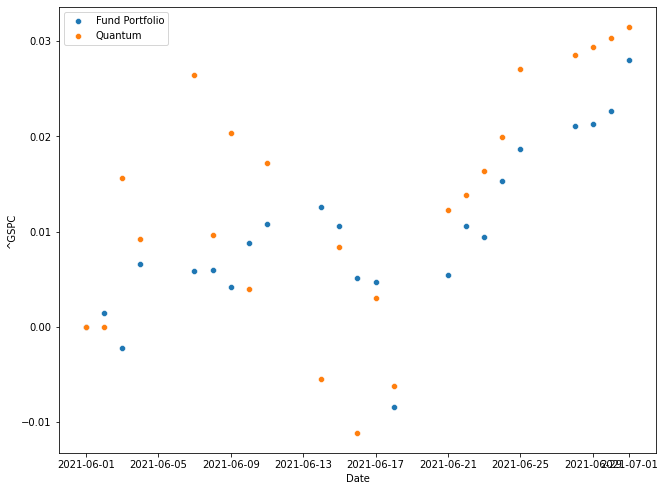


Run completed.

First round concluded


In [7]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()
df_init = pd.read_pickle(pickle_file)
cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.05,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.0,
            'label': 'Run96',
            'init_holdings': df_init.set_index('a').to_dict()['b'],
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}
locals().update(cfg)

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
stocks = first_table['Symbol'].values.tolist()

df, df_baseline = load_data(initial_date, dates, stocks, baseline)


my_portfolio = MultiPeriod(data=df,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=sampler_args,
                        dates=dates,
                        file_path=file_path,
                        model_type=model_type,
                        alpha=alpha,
                        verbose=verbose,
                        t_cost=t_cost,
                        label=label,
                        init_holdings=init_holdings,
                        save_path=save_path+label+'/'
                        )



my_portfolio.run(min_return=min_return, max_risk=max_risk, num=num)